In [24]:
import warnings

warnings.filterwarnings(action='ignore')

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_ef import FCFE
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [2]:
data_set = ChangeDetectionDataset('../data/annotated',
                                  '../data/train.csv',
                                  concat=True,
                                  patched=False
                                  )

In [3]:
len(data_set)

334

torch.Size([6, 128, 128]) torch.Size([128, 128])


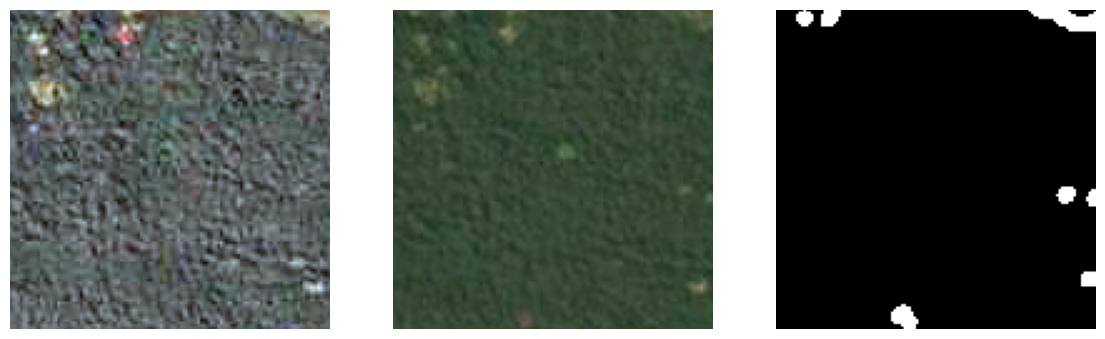

In [12]:
img, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(img[:3, ::].permute(1, 2, 0).numpy())
axes[1].imshow(img[3:, ::].permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

print(img.shape, label.shape)

In [5]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(9, 3)

### Modeling

In [6]:
model = FCFE(6, 3, classes=2)

In [7]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, cooldown=10)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=50)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [13]:
compiled.summary((6, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             880
       BatchNorm2d-2         [-1, 16, 128, 128]              32
           Dropout-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,320
       BatchNorm2d-5         [-1, 16, 128, 128]              32
           Dropout-6         [-1, 16, 128, 128]               0
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,640
       BatchNorm2d-9           [-1, 32, 64, 64]              64
          Dropout-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,248
      BatchNorm2d-12           [-1, 32, 64, 64]              64
          Dropout-13           [-1, 32, 64, 64]               0
        MaxPool2d-14           [-1, 32,


(dot.exe:9720): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


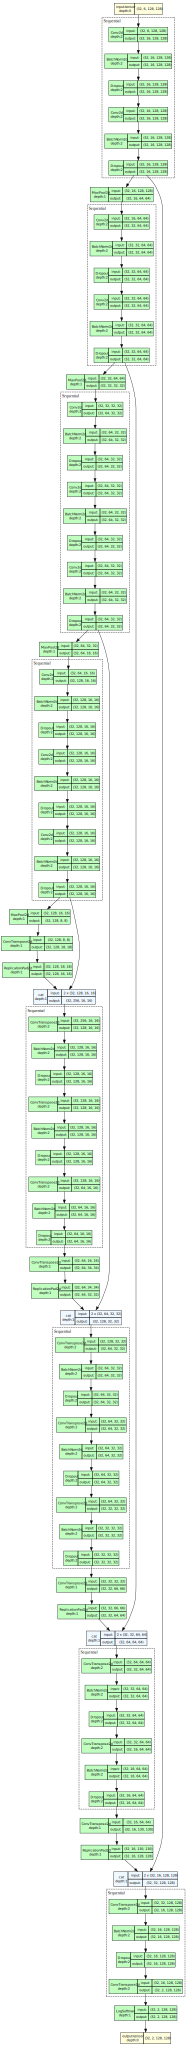

In [14]:
compiled.visual_graph((32, 6, 128, 128))

In [ ]:
w = torch.load('../data/class_weight.pt')
w

In [15]:
results = compiled.train(train_dataloader,
                         nn.NLLLoss(torch.FloatTensor([0.0962, 0.3]).cuda()),
                         300,
                         test_dataloader)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0/300
train loss: 0.9297765758302476
val loss: 1.0681971708933513
Epoch: 1/300
train loss: 0.8096648587120904
val loss: 3.653616746266683
Epoch: 2/300
train loss: 0.7631817658742269
val loss: 0.8491480350494385
Epoch: 3/300
train loss: 0.7245584593878852
val loss: 0.4674324293931325
Epoch: 4/300
train loss: 0.6950314177407159
val loss: 0.7012892166773478
Epoch: 5/300
train loss: 0.6725380222002665
val loss: 0.5752044916152954
Epoch: 6/300
train loss: 0.6296875410609775
val loss: 0.49323679010073346
Epoch: 7/300
train loss: 0.59279865026474
val loss: 0.43926989038785297
Epoch: 8/300
train loss: 0.5576653944121467
val loss: 0.39393388231595355
Epoch: 9/300
train loss: 0.5236547721756829
val loss: 0.3883038063844045
Epoch: 10/300
train loss: 0.47927403781149125
val loss: 0.44756002227465314
Epoch: 11/300
train loss: 0.4457400341828664
val loss: 0.4027787248293559
Epoch: 12/300
train loss: 0.45779820614390904
val loss: 0.5017902652422587
Epoch: 13/300
train loss: 0.43264332082536483

In [ ]:
# restore best checkpoint
# state = torch.load("./best_model.pth")
# model.load_state_dict(state['model_state_dict'])

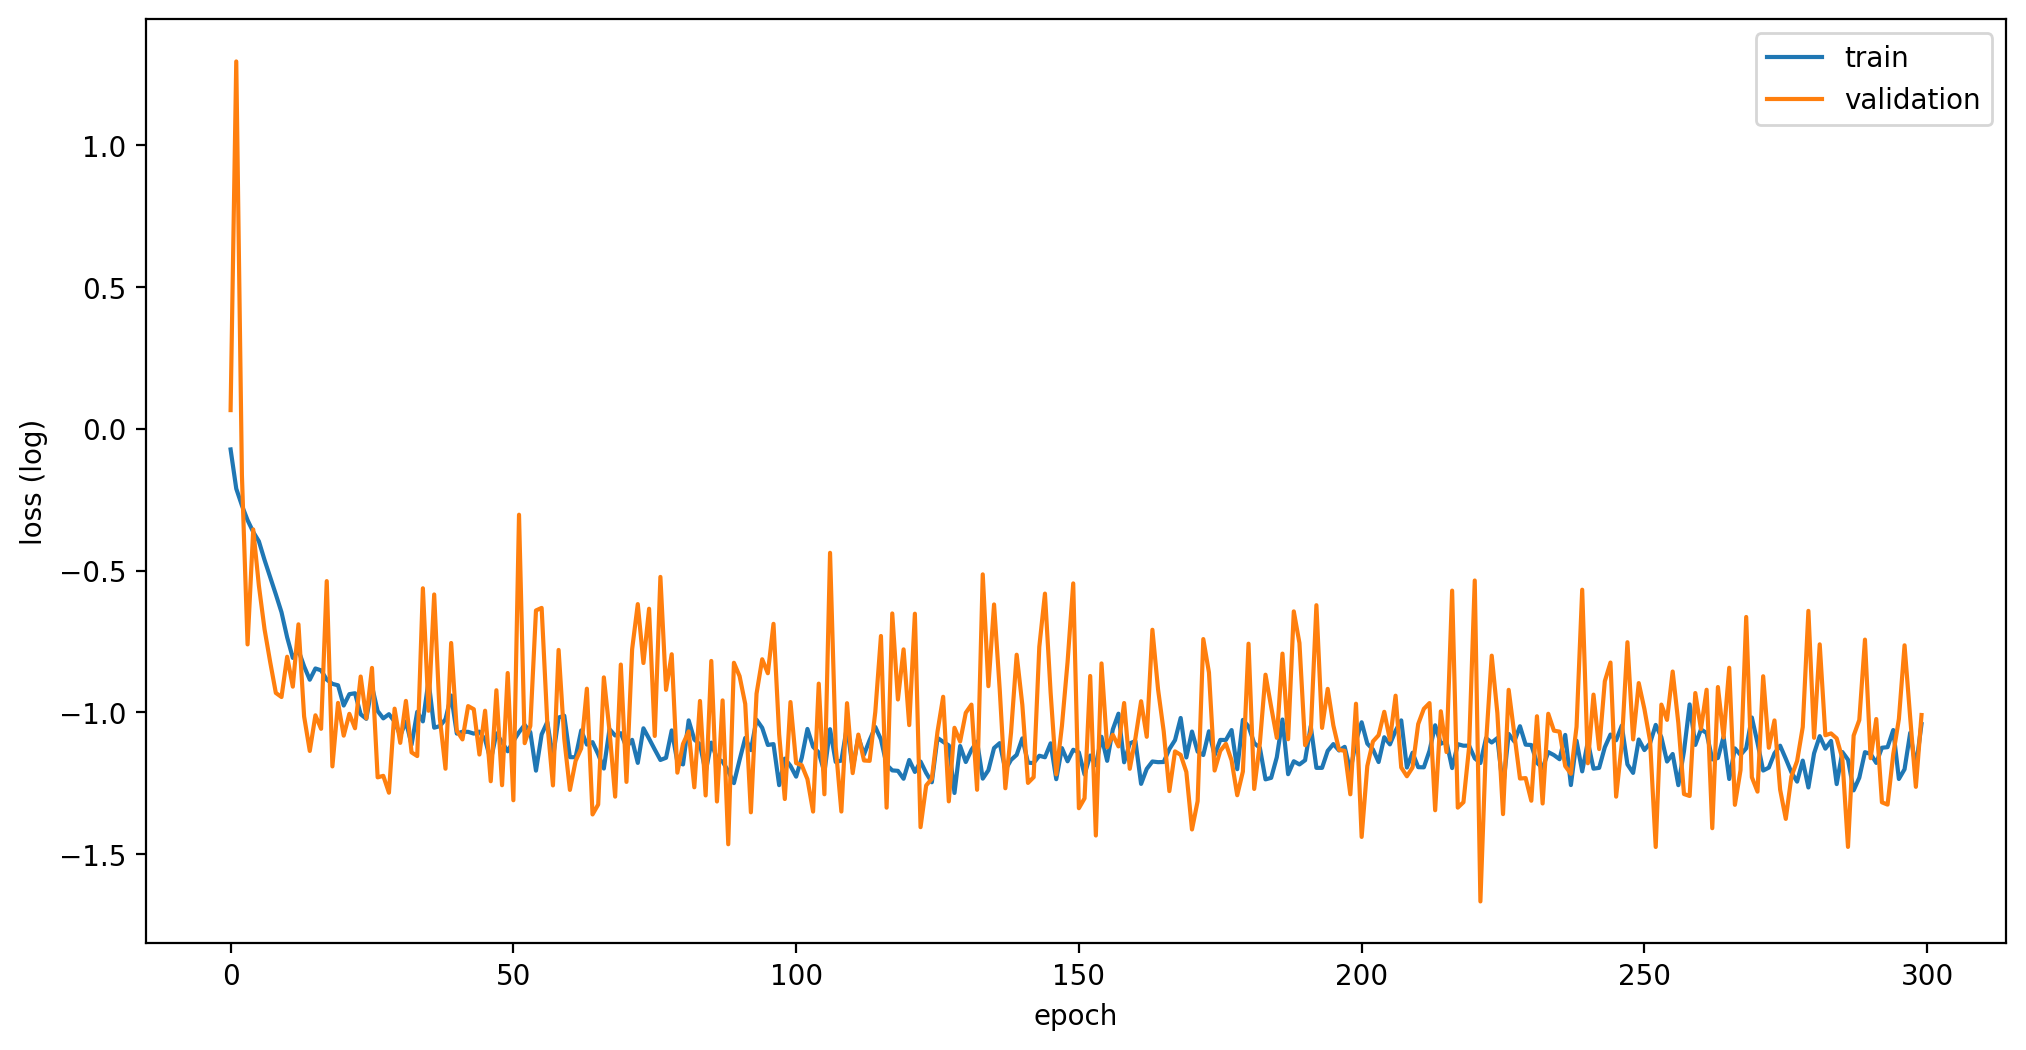

In [21]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(x=results['epoch'], y=np.log(results['train loss']), label='train')
sns.lineplot(x=results['epoch'], y=np.log(results['val loss']), label='validation')
plt.ylabel('loss (log)')
plt.show()

In [26]:
acc_test = 0
kappa_test = 0
dice_test = 0
recall_test = 0
precision_test = 0

for img, gt in tqdm(test_dataset):
    with torch.no_grad():
        model.eval()
        logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
        pred = torch.argmax(torch.sigmoid(logits), dim=0)

    acc_test += pixel_accuracy(gt, pred)
    kappa_test += precision(gt, pred)
    dice += recall(gt, pred)
    recall_test += recall(gt, pred)
    precision_test += precision(gt, pred)

print(acc_test / len(test_dataset),
      kappa_test / len(test_dataset),
      dice / len(test_dataset),
      recall_test / len(test_dataset),
      precision_test / len(test_dataset))

  0%|          | 0/67 [00:00<?, ?it/s]

tensor(0.9074) tensor(nan) tensor(nan) tensor(nan) tensor(nan)


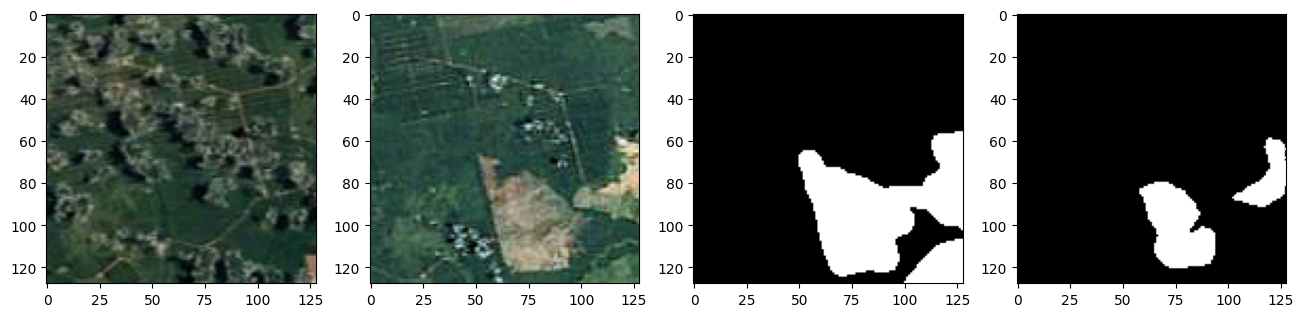

In [59]:
img, gt = test_dataset[np.random.randint(0, len(test_dataset))]

with torch.no_grad():
    model.eval()
    logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 4, 1)
plt.imshow(img[:3, ::].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(gt, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(img[3:, ::].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(pred, cmap='gray')